# 作者原实现 80epoch 水平翻转测试加权(0.011) 多阶段LR BCELoss

![](http://op4a94iq8.bkt.clouddn.com/18-9-2/22394851.jpg)

![](http://op4a94iq8.bkt.clouddn.com/18-9-3/22875224.jpg)

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split  # 分层分割数据集超方便的

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import load_img

/mnt/ml/anaconda35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 101
im_height = 128
im_chan = 3

basicpath = ''
path_train = basicpath + 'TrainData/'
path_test = basicpath + 'TestData/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

print("Training imgs path:",path_train_images)
print("Masks of training imgs path:",path_train_masks)
print("Test imgs path:",path_test_images)


Training imgs path: TrainData/images/
Masks of training imgs path: TrainData/masks/
Test imgs path: TestData/images/


In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df) # 每个id链接上相应的深度
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print("number of train：",len(train_df))
print(train_df.head(5))
print(depths_df.head(5))
test_df.head(5)

number of train： 4000
              z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
              z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783


,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [5]:
train_df["images"] = [np.array(load_img("TrainData/images/{}.png".format(idx), grayscale=True)) / 255
                              for idx in tqdm_notebook(train_df.index)]

train_df["masks"] = [np.array(load_img("TrainData/masks/{}.png".format(idx), grayscale=True))/ 255  
                              for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


A Jupyter Widget

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2) # 统计图片中像素为1的个数占整个图片101x101=10201个像素的比例

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)  #按照10%递增一档的比例进行阶梯分类

train_df.head(15)

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1
782ae9b7e7,677,"[[0.6078431372549019, 0.6196078431372549, 0.61...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.225370,3
9842f69f8d,907,"[[0.4392156862745098, 0.4117647058823529, 0.4,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
aa94cfb806,754,"[[0.5058823529411764, 0.49019607843137253, 0.4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.665817,7
50d3073821,810,"[[0.4666666666666667, 0.5333333333333333, 0.41...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.297030,3


/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

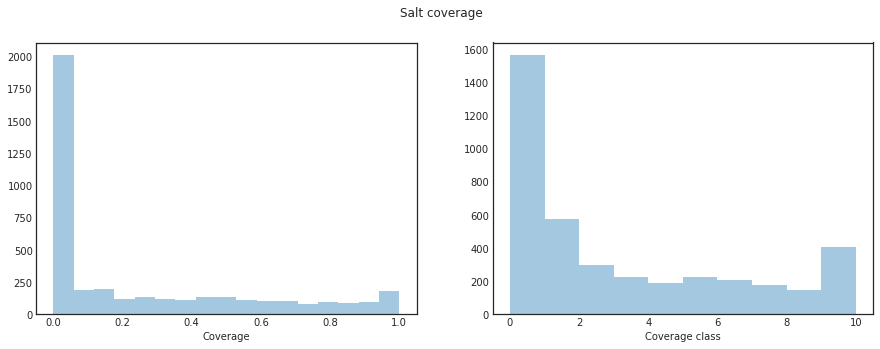

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

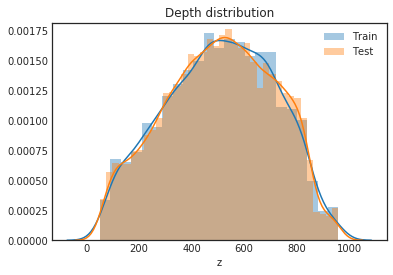

In [8]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [9]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), # [4000,101,101,1]
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), # [4000,101,101,1]
    train_df.coverage.values,# 4000个值
    train_df.z.values, # 4000个值
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)  
# !!!! stratify 分层split的指标 覆盖比例的等级  后面还可以使用深度等级分层split

print(ids_train.shape)
print(x_train.shape)
print(y_train.shape)
print(cov_train.shape)
print(depth_train.shape)
type(x_train) # all are np.ndarray
ids_valid[0:20]

(3200,)
(3200, 128, 128, 1)
(3200, 128, 128, 1)
(3200,)
(3200,)


array(['492383a53b', '3577258d6b', '3c1d07fc67', '89a74723fd',
       '4015200239', '38232d1fe3', 'fe85864f8f', '65a55b69b7',
       'a266a2a9df', 'af296d1c0a', 'b8dea42e1a', '0ad38c8f25',
       'b890b261a0', '96f8fd0d4b', '9c6f8e4676', 'd1857e0577',
       '8e84b940e3', '331ec135dd', 'e1009fa370', '12c92c9f70'],
      dtype=object)

![](http://op4a94iq8.bkt.clouddn.com/18-9-5/70500295.jpg)

In [10]:
print(x_valid.shape)
print(y_valid.shape)

(800, 128, 128, 1)
(800, 128, 128, 1)


In [11]:
mean= [0.485,0.456,0.406]
std=  [0.229,0.224,0.225]

x_train=np.concatenate((x_train-mean[2]/std[2],
                  x_train-mean[1]/std[1],
                  x_train-mean[0]/std[0]),axis=-1)

x_valid=np.concatenate((x_valid-mean[2]/std[2],
                  x_valid-mean[1]/std[1],
                  x_valid-mean[0]/std[0]),axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(3200, 128, 128, 3)
(3200, 128, 128, 1)
(800, 128, 128, 3)
(800, 128, 128, 1)


# 模型定义模块

In [1]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

In [2]:
# # 反卷积计算示例
# a_Deconv=nn.ConvTranspose2d(256,128,3,stride=2,\
#                                          padding=1,output_padding=1,bias=True, dilation=1)
# x=torch.randn(2,256,6,6)
# out=a_Deconv(x)
# out.shape

In [3]:

# class Conv2D_block(nn.Module):
#     def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
#         super().__init__()
        
#         padding={}
#         if filter_size==3:
#             padding["SAME"]=1
#         if filter_size==1:
#             padding["SAME"]=0
#         padding["VALID"]=0
        
#         self.Conv=nn.Conv2d(C_in, C_out, filter_size, stride=1,padding=padding[paddingType])
#         self.BN=nn.BatchNorm2d(C_out)
#         self.ActionType=ActionType
        
#     def forward(self,x):
#         out=self.Conv(x)
#         out=self.BN(out)
#         if self.ActionType=="Relu":
#             out=F.relu6(out,inplace=True)
#         return out
            
# class Residual_block(nn.Module):
#     def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
#         super().__init__()
        
#         self.BN=nn.BatchNorm2d(C_in)
#         self.Conv1=Conv2D_block(C_in,C_out,filter_size,paddingType,ActionType)
#         self.Conv2=Conv2D_block(C_out,C_out,filter_size,paddingType,ActionType=None)
        
#     def forward(self,x):
#         out=F.relu6(x,inplace=True)
#         out=self.BN(out)
#         out=self.Conv1(out)
#         out=self.Conv2(out)
#         out=out+x  # skip connection
#         return out

# class Eecoder_with_residual_block(nn.Module):
    
#     def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
#         super().__init__()
        
#         padding={}
#         if filter_size==3:
#             padding["SAME"]=1
#         if filter_size==1:
#             padding["SAME"]=0
#         padding["VALID"]=0
        
#         self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
#         self.Res_1=Residual_block(C_out,C_out)
#         self.Res_2=Residual_block(C_out,C_out)
    
#     def forward(self,x):
#         out=self.Conv_1(x)
#         out=self.Res_1(out)
#         out=self.Res_2(out)
#         out=F.relu6(out,inplace=True)
#         return out

# class Decoder_with_residual_block(nn.Module):
    
#     def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
#         super().__init__()
        
#         padding={}
#         if filter_size==3:
#             padding["SAME"]=1
#         if filter_size==1:
#             padding["SAME"]=0
#         padding["VALID"]=0  
        
#         if paddingType=="VALID":
#             output_padding=0
#         else:
#             output_padding=1
            
#         self.Deconv_1=nn.ConvTranspose2d(C_in,C_out,filter_size, stride=2,\
#                                          padding=padding[paddingType],output_padding=output_padding,bias=True, dilation=1)
#         self.Dropout=nn.Dropout(DropoutRatio)
#         self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=1)
#         self.Res_1=Residual_block(C_out,C_out)
#         self.Res_2=Residual_block(C_out,C_out)
    
#     def forward(self,x,skipx):
#         out=self.Deconv_1(x)
#         out=torch.cat([out,skipx],dim=1)
#         out=self.Dropout(out)
        
#         out=self.Conv_1(out)
#         out=self.Res_1(out)
#         out=self.Res_2(out)
#         out=F.relu6(out,inplace=True)
#         return out
        
# class Middle_with_residual_block(nn.Module):
    
#     def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
#         super().__init__()
        
#         padding={}
#         if filter_size==3:
#             padding["SAME"]=1
#         if filter_size==1:
#             padding["SAME"]=0
#         padding["VALID"]=0
            
#         self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
#         self.Res_1=Residual_block(C_out,C_out)
#         self.Res_2=Residual_block(C_out,C_out)
       
#     def forward(self,x):
#         out=self.Conv_1(x)
#         out=self.Res_1(out)
#         out=self.Res_2(out)
#         out=F.relu6(out,inplace=True)
#         return out
    
# class U_net_with_residual(nn.Module):
    
#     def __init__(self,filter_num=16,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
#         super().__init__()
        
#         self.Dropout_1=nn.Dropout(DropoutRatio/2)
#         self.Dropout_2=nn.Dropout(DropoutRatio)
        
#         self.Encoder_L1=Eecoder_with_residual_block(im_chan,filter_num,DropoutRatio/2)
#         self.Encoder_L2=Eecoder_with_residual_block(filter_num*1,filter_num*2,DropoutRatio)
#         self.Encoder_L3=Eecoder_with_residual_block(filter_num*2,filter_num*4,DropoutRatio)
#         self.Encoder_L4=Eecoder_with_residual_block(filter_num*4,filter_num*8,DropoutRatio)
        
#         self.Middle=Middle_with_residual_block(filter_num*8,filter_num*16,DropoutRatio)
        
#         self.Decoder_L4=Decoder_with_residual_block(filter_num*16,filter_num*8,DropoutRatio,paddingType="SAME")
#         self.Decoder_L3=Decoder_with_residual_block(filter_num*8,filter_num*4,DropoutRatio,paddingType="VALID")
#         self.Decoder_L2=Decoder_with_residual_block(filter_num*4,filter_num*2,DropoutRatio,paddingType="SAME")
#         self.Decoder_L1=Decoder_with_residual_block(filter_num*2,filter_num*1,DropoutRatio,paddingType="VALID")
        
    
#         self.Out=nn.Conv2d(filter_num,1,1,stride=1,padding=0)
        
#     def forward(self,x):
#         Encoder_L1=self.Encoder_L1(x)
#         Pool_L1=F.max_pool2d(Encoder_L1,2, stride=2)
#         Pool_L1=self.Dropout_1(Pool_L1)
        
#         Encoder_L2=self.Encoder_L2(Pool_L1)
#         Pool_L2=F.max_pool2d(Encoder_L2,2, stride=2)
#         Pool_L2=self.Dropout_2(Pool_L2)
        
#         Encoder_L3=self.Encoder_L3(Pool_L2)
#         Pool_L3=F.max_pool2d(Encoder_L3,2, stride=2)
#         Pool_L3=self.Dropout_2(Pool_L3)
        
#         Encoder_L4=self.Encoder_L4(Pool_L3)
#         Pool_L4=F.max_pool2d(Encoder_L4,2, stride=2)
#         Pool_L4=self.Dropout_2(Pool_L4)
        
#         Middle=self.Middle(Pool_L4)
        
#         Summary=False
#         if Summary:
#             print("1:",Encoder_L1.shape)
#             print("2:",Encoder_L2.shape)
#             print("3:",Encoder_L3.shape)
#             print("4:",Encoder_L4.shape)
#             print("5:",Middle.shape)
        
        
#         Decoder_L4=self.Decoder_L4(Middle,Encoder_L4)
#         Decoder_L3=self.Decoder_L3(Decoder_L4,Encoder_L3)
#         Decoder_L2=self.Decoder_L2(Decoder_L3,Encoder_L2)
#         Decoder_L1=self.Decoder_L1(Decoder_L2,Encoder_L1)
        
#         if Summary:
#             print("6:",Decoder_L4.shape)
#             print("7:",Decoder_L3.shape)
#             print("8:",Decoder_L2.shape)
#             print("9:",Decoder_L1.shape)
            
#         logits=self.Dropout_1(Decoder_L1)
#         logits=self.Out(logits)
#         #loits=F.sigmoid(logits)
        
#         if Summary:
#             print("10:",logits.shape)
        
#         return logits
        

In [8]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision

"""
This script has been taken (and modified) from :
https://github.com/ternaus/TernausNet
@ARTICLE{arXiv:1801.05746,
         author = {V. Iglovikov and A. Shvets},
          title = {TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation},
        journal = {ArXiv e-prints},
         eprint = {1801.05746}, 
           year = 2018
        }
"""

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x
    

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNetResNet(nn.Module):
    """PyTorch U-Net model using ResNet(34, 101 or 152) encoder.
    UNet: https://arxiv.org/abs/1505.04597
    ResNet: https://arxiv.org/abs/1512.03385
    Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
    Args:
            encoder_depth (int): Depth of a ResNet encoder (34, 101 or 152).
            num_classes (int): Number of output classes.
            num_filters (int, optional): Number of filters in the last layer of decoder. Defaults to 32.
            dropout_2d (float, optional): Probability factor of dropout layer before output layer. Defaults to 0.2.
            pretrained (bool, optional):
                False - no pre-trained weights are being used.
                True  - ResNet encoder is pre-trained on ImageNet.
                Defaults to False.
            is_deconv (bool, optional):
                False: bilinear interpolation is used in decoder.
                True: deconvolution is used in decoder.
                Defaults to False.
    """

    def __init__(self, encoder_depth, num_classes, num_filters=32, dropout_2d_ration=0.5,
                 pretrained=False, is_deconv=False):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d_ratio = dropout_2d_ration

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError('only 34, 101, 152 version of Resnet are implemented')

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(bottom_channel_nr, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec5 = DecoderBlockV2(bottom_channel_nr + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(bottom_channel_nr // 2 + num_filters * 8, num_filters * 8 * 2, num_filters * 8,
                                   is_deconv)
        self.dec3 = DecoderBlockV2(bottom_channel_nr // 4 + num_filters * 8, num_filters * 4 * 2, num_filters * 2,
                                   is_deconv)
        self.dec2 = DecoderBlockV2_NoDouble(bottom_channel_nr // 8 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2,
                                   is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        print("x:",x.shape)
        
        conv1 = self.conv1(x)
        conv1=F.dropout2d(conv1, p=self.dropout_2d_ratio/2)
        print("conv1:",conv1.shape)
        
        conv2 = self.conv2(conv1)
        conv2=F.dropout2d(conv2, p=self.dropout_2d_ratio)
        print("conv2:",conv2.shape)
        
        conv3 = self.conv3(conv2)
        conv3=F.dropout2d(conv3, p=self.dropout_2d_ratio)
        print("conv3:",conv3.shape)
        
        conv4 = self.conv4(conv3)
        conv4=F.dropout2d(conv4, p=self.dropout_2d_ratio)
        print("conv4:",conv4.shape)
        
        conv5 = self.conv5(conv4)
        conv5=F.dropout2d(conv5, p=self.dropout_2d_ratio)
        print("conv5:",conv5.shape)
        
        
        pool = self.pool(conv5)
        print("pool:",pool.shape)
        
        center = self.center(pool)
        print("center:",center.shape)
        
        tmp=torch.cat([center, conv5],1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio)
        dec5 = self.dec5(tmp)
        print("dec5:",dec5.shape)
    
        tmp=torch.cat([dec5, conv4],1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio)
        dec4 = self.dec4(tmp)
        print("dec4:",dec4.shape)
        
        tmp=torch.cat([dec4, conv3], 1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio)
        dec3 = self.dec3(tmp)
        print("dec3:",dec3.shape)
        
        tmp=torch.cat([dec3, conv2], 1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio)
        dec2 = self.dec2(tmp)
        print("dec2:",dec2.shape)
        
        dec2=F.dropout2d(dec2, p=self.dropout_2d_ratio/2)
        dec1 = self.dec1(dec2)
        print("dec1:",dec1.shape)
        
        dec1=F.dropout2d(dec1, p=self.dropout_2d_ratio/2)
        dec0 = self.dec0(dec1)
        print("dec0:",dec0.shape)
        
        logits=self.final(F.dropout2d(dec0, p=self.dropout_2d_ratio/2))
        print("logits:",logits.shape)
        return logits

In [12]:
import time 
since=time.time()

x=torch.randn(32,3,128,128).cuda()

model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=32, dropout_2d_ration=0.5,pretrained=True)

model.cuda()

out=model(x)

x: torch.Size([32, 3, 128, 128])
conv1: torch.Size([32, 64, 64, 64])
conv2: torch.Size([32, 64, 64, 64])
conv3: torch.Size([32, 128, 32, 32])
conv4: torch.Size([32, 256, 16, 16])
conv5: torch.Size([32, 512, 8, 8])
pool: torch.Size([32, 512, 4, 4])
center: torch.Size([32, 256, 8, 8])
dec5: torch.Size([32, 256, 16, 16])
dec4: torch.Size([32, 256, 32, 32])
dec3: torch.Size([32, 64, 64, 64])
dec2: torch.Size([32, 128, 128, 128])
dec1: torch.Size([32, 32, 256, 256])
dec0: torch.Size([32, 32, 256, 256])
logits: torch.Size([32, 1, 256, 256])


/mnt/ml/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


![](http://op4a94iq8.bkt.clouddn.com/18-9-5/28793794.jpg)

# 指标计算

In [17]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("this batch metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    '''
    tf.py_func接收的是tensor，然后将其转化为numpy array送入func函数，最后再将func函数输出的numpy array转化为tensor返回。
    ref: https://blog.csdn.net/tiankongtiankong01/article/details/80568311
    '''
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

# 准备训练数据并训练

In [18]:
#Data augmentation
x_train2 = np.transpose(np.append(x_train, [np.fliplr(x) for x in x_train], axis=0),(0,3,1,2)).astype(np.float32)
y_train2 = np.transpose(np.append(y_train, [np.fliplr(x) for x in y_train], axis=0),(0,3,1,2)).astype(np.float32)
x_valid2 = np.transpose(x_valid,(0,3,1,2)).astype(np.float32)
y_valid2 = np.transpose(y_valid,(0,3,1,2)).astype(np.float32)

print(x_train2.shape)
print(y_train2.shape)
print(x_valid2.shape)
print(y_valid2.shape)  # !!!不要对valid进行数据增强
print(type(x_train2[0,0,0,0]))
print(type(x_valid2[0,0,0,0]))

(6400, 3, 128, 128)
(6400, 1, 128, 128)
(800, 3, 128, 128)
(800, 1, 128, 128)
<class 'numpy.float32'>
<class 'numpy.float32'>


In [19]:
# 自定义一个Pytorch的数据加载器,必须继承自torch.utils.data.Dataset
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [20]:
salt_ID_dataset_train = saltIDDataset(x_train2, 
                                      train=True, 
                                      preprocessed_masks=y_train2)

salt_ID_dataset_val = saltIDDataset(x_valid2, 
                                      train=True, 
                                      preprocessed_masks=y_valid2)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

print("Trainng samples:",train_loader.dataset.__len__())
print("Validation samples:",val_loader.dataset.__len__())

Trainng samples: 6400
Validation samples: 800


In [21]:
class ArgParser(object):
    def __init__(self):
        
        self.MaxEpoch=60
        self.LR_Policy="MultiStage"
        
        self.n_gpus=1
        
        self.load_pretrained_model=False
        self.pretarined_model_path="Results"
        
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.start_save_epoch=30
        self.save_step=2

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.eps = eps

    def forward(self, output, target):
        return 1 - (2 * torch.sum(output * target) + self.smooth) / (
                torch.sum(output) + torch.sum(target) + self.smooth + self.eps)

In [23]:
def LearningRateAdjust(LR_Policy,optimizer,cur_epoch,history_metirc):
    if LR_Policy=="MultiSatge":
        if cur_epoch==1:
            lr=0.002
        elif cur_epoch==30:
            lr=0.001
        elif cur_epoch==45:
            lr=0.0005
        elif cur_epoch==50:
            lr=0.0001
        else:
            return
        
        for param_group in optimizer.param_groups:
            param_group["lr"]=lr

In [24]:
import time
import shutil
        
def custom_weights_init(m):
    pass 

def save_checkpoint(state, is_best, path,args):
    save_path=os.path.join(path,'saved_Gpu_model_state.pt')
    torch.save(state, save_path)
    if is_best:
        shutil.copyfile(save_path, 
                        os.path.join(args.pretarined_model_path ,'best_Gpu_model_state.pt'))

    
def train(model,train_loader,optimizer,criterion,args,epoch,class_weights,Dice_loss):
    since=time.time()
    model.train()
    train_losses = []
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss_1 = criterion(logits, masks)
        loss_2=Dice_loss(F.sigmoid(logits), masks)
        
        combine_cofficient=1
        loss=combine_cofficient*loss_1+(1-combine_cofficient)*loss_2
        
        train_losses.append(loss.data)
        
        #dice_loss = bioloss.dice_error(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if batch_idx%20==0:
#             now=time.time()
#             print("Loss:{},escaped time:{}".format(loss,now-since))
#             since=now
#             #break
            
    now=time.time()
    mean_loss=np.mean(train_losses)
    print("Mean Train Loss:{},escaped time:{}".format(mean_loss,now-since))
    return mean_loss

def test(model,test_loader,criterion,args,epoch,class_weights,Dice_loss):
    since=time.time()
    model.eval()
    test_losses = []
    
    for batch_idx, (images, masks) in enumerate(test_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss_1 = criterion(logits, masks)
        loss_2=Dice_loss(F.sigmoid(logits), masks)
        
        combine_cofficient=1
        loss=combine_cofficient*loss_1+(1-combine_cofficient)*loss_2
        
        test_losses.append(loss.data)
        #dice_loss = bioloss.dice_error(output, target)
        
    now=time.time()
    mean_loss=np.mean(test_losses)
    print("Mean Val Loss:{},escaped time:{}".format(mean_loss,now-since))
            
    return mean_loss
   
train_losses_history=[]
val_losses_history=[]

def main():
    
    args=ArgParser()
    
    torch.cuda.manual_seed_all(4200)# 设置全局固定随机种子方便复现
    np.random.seed(133700)
    
#     model=U_net_with_residual(16) # 16 is the basic filter_nums, for controlling the width of U-Net
    model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=16, dropout_2d_ration=0.8,pretrained=True)
    
#     gpu_ids=range(args.n_gpus)
#     model=nn.parallel.DataParallel(model,device_ids=gpu_ids)
    
    if args.load_pretrained_model==True:
        state=torch.load(args.pretarined_model_path)
        model.load_state_dict(state)
    else:
        model.apply(custom_weights_init)    
    
    # deploy model to GPU or CPU
    model.to(args.device)
    
    # -------------------------------------------------------------------------------- #
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()
    # -------------------------------------------------------------------------------- #
    Dice_loss=DiceLoss(smooth=1)
    
    
    class_weights=[0.5,0.5] 
    
    best_metric=100  # 注意指标的大小与性能的关系
    metirc_history=[]
    for epoch in range(1,args.MaxEpoch):
        LearningRateAdjust(args.LR_Policy,optimizer,epoch,metirc_history)
        
        mean_train_loss_=train(model,train_loader,optimizer,criterion,args,epoch,class_weights,Dice_loss)
        train_losses_history.append(mean_train_loss_)
        
        mean_val_loss_=test(model,val_loader,criterion,args,epoch,class_weights,Dice_loss)
        val_losses_history.append(mean_val_loss_)
        
        if  epoch>=args.start_save_epoch :
            if mean_val_loss_<best_metric:
                best_metric=mean_val_loss_
                is_best=True
                save_checkpoint(model.state_dict(), is_best, args.pretarined_model_path,args)
            else:
                is_best=False
                if epoch % args.save_step ==0:
#                     save_path=os.path.join(args.pretarined_model_path,str(epoch))
#                     if not os.path.exists(save_path):
#                         os.mkdir(save_path)
#                     save_checkpoint(model.state_dict(), is_best, save_path, args)
                    torch.save(model.state_dict(),"Results/MM_{}.pt".format(epoch))
    torch.save(model.state_dict(),"Results/MM.pt")
    return model

   
    

![](http://op4a94iq8.bkt.clouddn.com/18-9-4/76928144.jpg)

In [28]:
model=main()

train_loss_series = pd.Series(train_losses_history)
val_loss_series = pd.Series(val_losses_history)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:10<00:00, 8354781.50it/s] 
/mnt/ml/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Mean Train Loss:0.41191595792770386,escaped time:39.753209829330444
Mean Val Loss:0.43105262517929077,escaped time:1.5953917503356934
Mean Train Loss:0.2719200849533081,escaped time:39.72522854804993
Mean Val Loss:0.2769571542739868,escaped time:1.6016871929168701
Mean Train Loss:0.23014751076698303,escaped time:39.75101900100708
Mean Val Loss:0.29405421018600464,escaped time:1.6042873859405518
Mean Train Loss:0.19841910898685455,escaped time:39.78574538230896
Mean Val Loss:0.1852065473794937,escaped time:1.597484827041626
Mean Train Loss:0.17505007982254028,escaped time:39.794458627700806
Mean Val Loss:0.19053076207637787,escaped time:1.6028656959533691
Mean Train Loss:0.15623679757118225,escaped time:39.80159831047058
Mean Val Loss:0.4508691132068634,escaped time:1.6111266613006592
Mean Train Loss:0.15316087007522583,escaped time:39.80487871170044
Mean Val Loss:0.19836683571338654,escaped time:1.6036310195922852
Mean Train Loss:0.15582041442394257,escaped time:39.796340227127075
Mean

In [22]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

In [26]:
MODELS_NAME[0][0]

'M'

(800, 3, 128, 128)


/mnt/ml/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7175564765930176


A Jupyter Widget

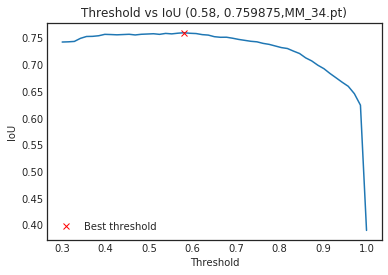

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7182836532592773


A Jupyter Widget

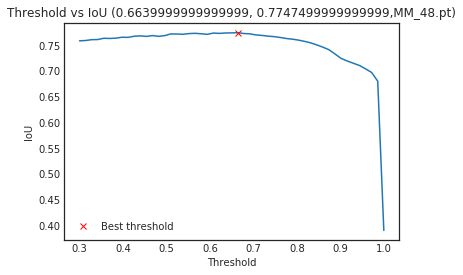

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7248625755310059


A Jupyter Widget

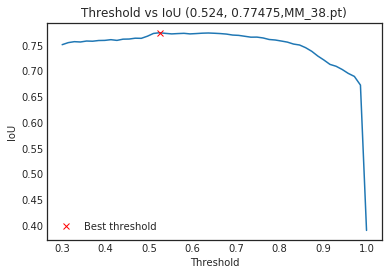

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.735971450805664


A Jupyter Widget

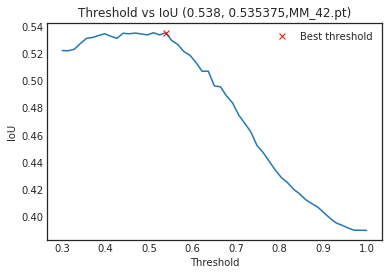

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7203166484832764


A Jupyter Widget

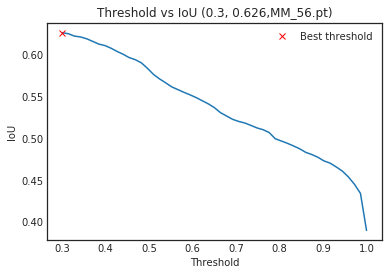

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.734450340270996


A Jupyter Widget

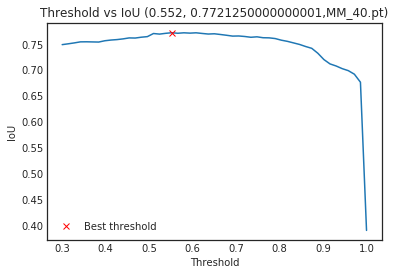

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7312803268432617


A Jupyter Widget

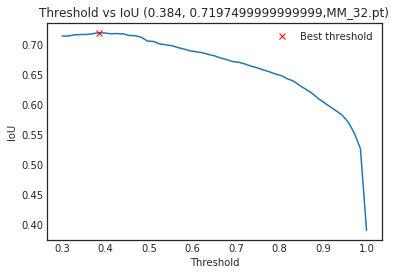

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.710602045059204


A Jupyter Widget

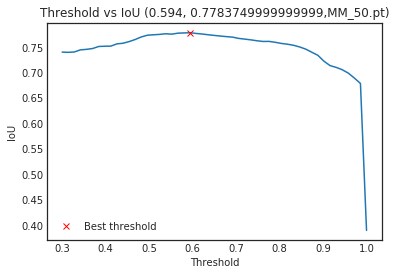

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.722402572631836


A Jupyter Widget

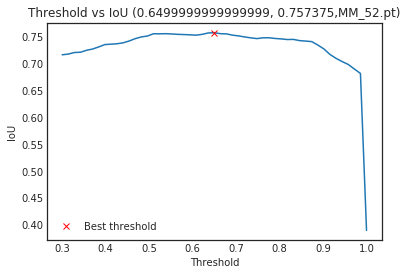

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7127699851989746


A Jupyter Widget

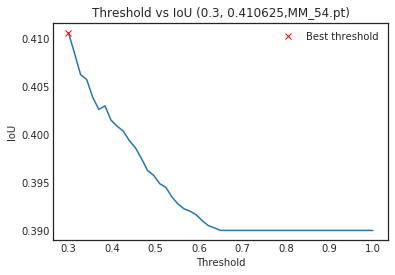

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.730250358581543


A Jupyter Widget

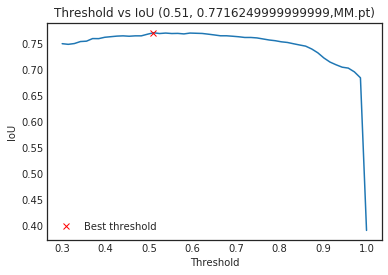

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.720334768295288


A Jupyter Widget

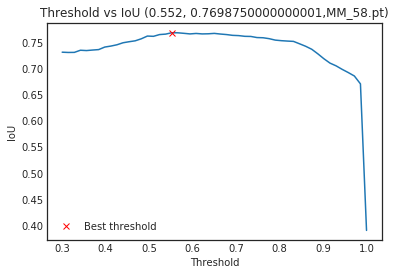

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7156085968017578


A Jupyter Widget

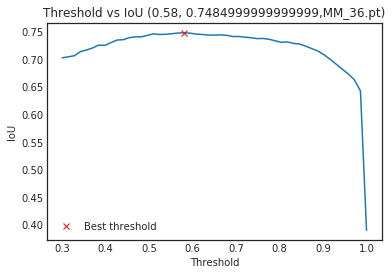

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.710137128829956


A Jupyter Widget

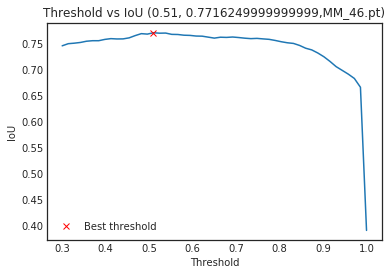

(800, 3, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
(800, 1, 128, 128)
cost time: 1.7078707218170166


A Jupyter Widget

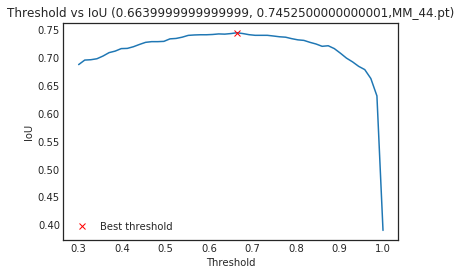

In [26]:
import os
MODELS_NAME=os.listdir("Results")

for model_name in MODELS_NAME:
    if model_name[0]!='M':
        continue
    #model=U_net_with_residual(16)
    model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=16, dropout_2d_ration=0.8,pretrained=False)


    state = torch.load('Results/{}'.format(model_name))#,map_location={'cuda:0': 'cpu'})  #
    model.load_state_dict(state) #,map_location='cpu'

    if torch.cuda.is_available():
        model=model.cuda()
    
    
    # ------------------------------------
    VAL_USE_SYM_FLAG=False

    x_valid_Sym=np.transpose(np.array([np.fliplr(x) for x in x_valid]),(0,3,1,2)).astype(np.float32)
    print(x_valid_Sym.shape)

    y_valid_Sym=np.zeros_like(x_valid_Sym).astype(np.float32)

    salt_ID_dataset_valid_Sym = saltIDDataset(x_valid_Sym, 
                                          train=True, 
                                          preprocessed_masks=y_valid_Sym)

    batch_size = 32

    valid_loader_Sym = torch.utils.data.DataLoader(dataset=salt_ID_dataset_valid_Sym, 
                                               batch_size=batch_size, 
                                               shuffle=False)

    mask_pred_valid_Sym = []
    model.eval()
    for images, masks in valid_loader_Sym:
        images = Variable(images.cuda())
    #     images = Variable(images)
        y_preds = model(images)
        y_preds=F.sigmoid(y_preds)


        for i, _ in enumerate(images):
            y_pred = y_preds[i] 
            y_pred = y_pred.cpu().data.numpy()
            mask_pred_valid_Sym.append(y_pred[:,:,::-1])



    mask_pred_valid_Sym=np.array(mask_pred_valid_Sym) 
    print(mask_pred_valid_Sym.shape)

    VAL_USE_SYM_FLAG=True



    import time
    since=time.time()

    mask_pred_valid = []
    mask_truth_valid=[]

    model.eval()
    for images, masks in val_loader:
        images = Variable(images.cuda())
    #     images = Variable(images)
        y_preds = model(images)
        y_preds=F.sigmoid(y_preds)

        for i, _ in enumerate(images):
            y_pred = y_preds[i] 
            y_pred = y_pred.cpu().data.numpy()
            mask_pred_valid.append(y_pred)
            mask_truth_valid.append(masks[i].numpy())


    mask_pred_valid=np.array(mask_pred_valid)
    mask_truth_valid=np.array(mask_truth_valid)       
    print(mask_truth_valid.shape)
    print(mask_truth_valid.shape)

    if VAL_USE_SYM_FLAG:
        mask_pred_valid=0.5*(mask_pred_valid+mask_pred_valid_Sym)

    print("cost time:",time.time()-since)
    
    import gc
    del x_valid_Sym
    del y_valid_Sym
    del salt_ID_dataset_valid_Sym
    del valid_loader_Sym
    gc.collect()
    
    
    # Scoring for last model
    thresholds = np.linspace(0.3, 1, 51)
    ious = np.array([iou_metric_batch(mask_truth_valid, np.int32(mask_pred_valid > threshold)) 
                     for threshold in tqdm_notebook(thresholds)])

    # thresholds = np.linspace(0.3, 0.9,121 )
    # ious = np.array([iou_metric_batch(mask_truth_valid, np.int32(mask_pred_valid > threshold)) 
    #                  for threshold in tqdm_notebook(thresholds)])


    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {},{})".format(threshold_best, iou_best,model_name))
    plt.legend()
    plt.show()
    

A Jupyter Widget

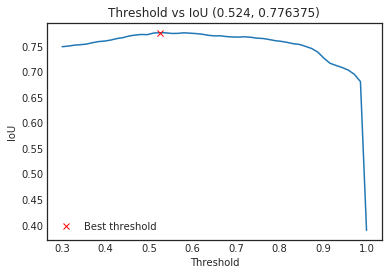

In [25]:
# # Scoring for last model
# thresholds = np.linspace(0.3, 1, 51)
# ious = np.array([iou_metric_batch(mask_truth_valid, np.int32(mask_pred_valid > threshold)) 
#                  for threshold in tqdm_notebook(thresholds)])

# # thresholds = np.linspace(0.3, 0.9,121 )
# # ious = np.array([iou_metric_batch(mask_truth_valid, np.int32(mask_pred_valid > threshold)) 
# #                  for threshold in tqdm_notebook(thresholds)])


# threshold_best_index = np.argmax(ious) 
# iou_best = ious[threshold_best_index]
# threshold_best = thresholds[threshold_best_index]

# plt.plot(thresholds, ious)
# plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
# plt.xlabel("Threshold")
# plt.ylabel("IoU")
# plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
# plt.legend()

# 可以完美复现 在众多模型中根据最佳阈值选择最佳模型  

* 用os.listdir()获取所有保存的模型的名字 然后写个循环把最佳模型找出来


# 准备测试数据并测试

In [52]:
#model=U_net_with_residual(16)
model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=16, dropout_2d_ration=0.8,pretrained=False)


state = torch.load('Results/{}'.format("MM.pt"))#,map_location={'cuda:0': 'cpu'})  #
model.load_state_dict(state) #,map_location='cpu'

if torch.cuda.is_available():
    model=model.cuda()

In [54]:
# 指定最佳阈值
threshold_best=0.51

In [55]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [56]:
x_test = np.array([upsample((np.array(load_img("TestData/images/{}.png".format(idx), grayscale = True))) / 255) for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [57]:
x_test.shape

(18000, 128, 128, 1)

In [58]:
mean= [0.485,0.456,0.406]
std=  [0.229,0.224,0.225]

x_test=np.concatenate((x_test-mean[2]/std[2],
                  x_test-mean[1]/std[1],
                  x_test-mean[0]/std[0]),axis=-1)

print(x_test.shape)

(18000, 128, 128, 3)


In [59]:
x_test2=np.transpose(x_test,(0,3,1,2)).astype(np.float32)
print(x_test2.shape)
y_test2=np.zeros_like(x_test2).astype(np.float32)

salt_ID_dataset_test = saltIDDataset(x_test2, 
                                      train=True, 
                                      preprocessed_masks=y_test2)

batch_size = 32

test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 3, 128, 128)


In [60]:
x_test_Sym=np.transpose(np.array([np.fliplr(x) for x in x_test]),(0,3,1,2)).astype(np.float32)
print(x_test_Sym.shape)

y_test_Sym=np.zeros_like(x_test_Sym).astype(np.float32)

salt_ID_dataset_test_Sym = saltIDDataset(x_test_Sym, 
                                      train=True, 
                                      preprocessed_masks=y_test_Sym)

batch_size = 32

test_loader_Sym = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test_Sym, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 3, 128, 128)


In [61]:
mask_pred_test_Sym = []
model.eval()
for images, masks in test_loader_Sym:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    y_preds=F.sigmoid(y_preds)
    
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test_Sym.append(y_pred[:,:,::-1])
       
        
        
mask_pred_test_Sym=np.array(mask_pred_test_Sym) 
print(mask_pred_test_Sym.shape)


/mnt/ml/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(18000, 1, 128, 128)


In [62]:
import time
since=time.time()

mask_pred_test = []
model.eval()
for images, masks in test_loader:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    y_preds=F.sigmoid(y_preds)
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test.append(y_pred)
       

        
mask_pred_test=np.array(mask_pred_test) 
print(mask_pred_test.shape)
mask_pred_test=0.5*(mask_pred_test+mask_pred_test_Sym)

print("cost time:",time.time()-since)

/mnt/ml/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(18000, 1, 128, 128)
cost time: 39.17193126678467


In [66]:
threshold_best

0.51

In [67]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(np.transpose(downsample(np.transpose(mask_pred_test[i],(1,2,0))),(2,0,1)) > threshold_best))
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

A Jupyter Widget


Usedtime = 24.021095037460327 s


In [68]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_CCC.csv')

# CRF后处理(CPU模式下运行)

### 安装pydensecrf   
```shell
apt-get update
source /etc/profile 
conda install gxx_linux-64
pip install pydensecrf
```

In [69]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
%matplotlib inline

In [70]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

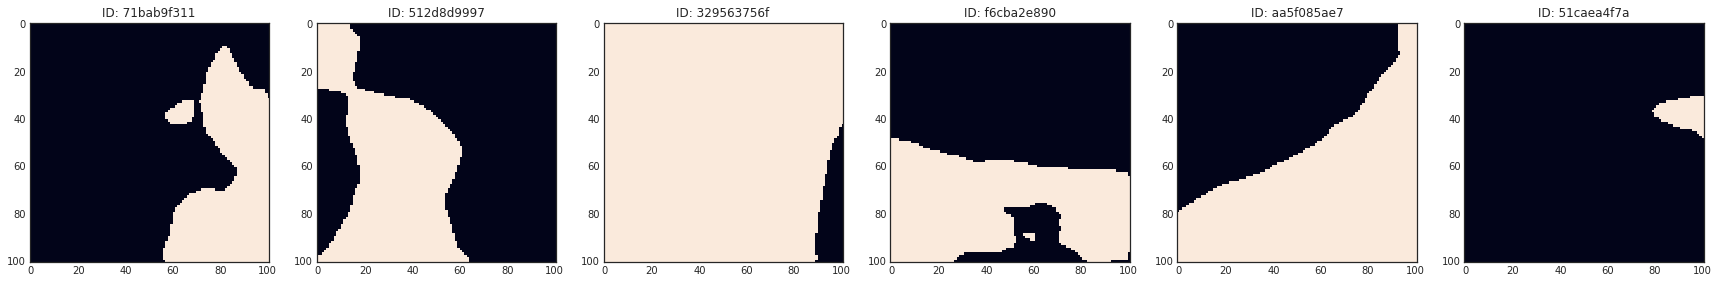

In [71]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('submission_CCC.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

# Function to apply CRF

In [72]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [73]:
test_path = 'TestData/images/'

# Visualizing the effect of applying CRF

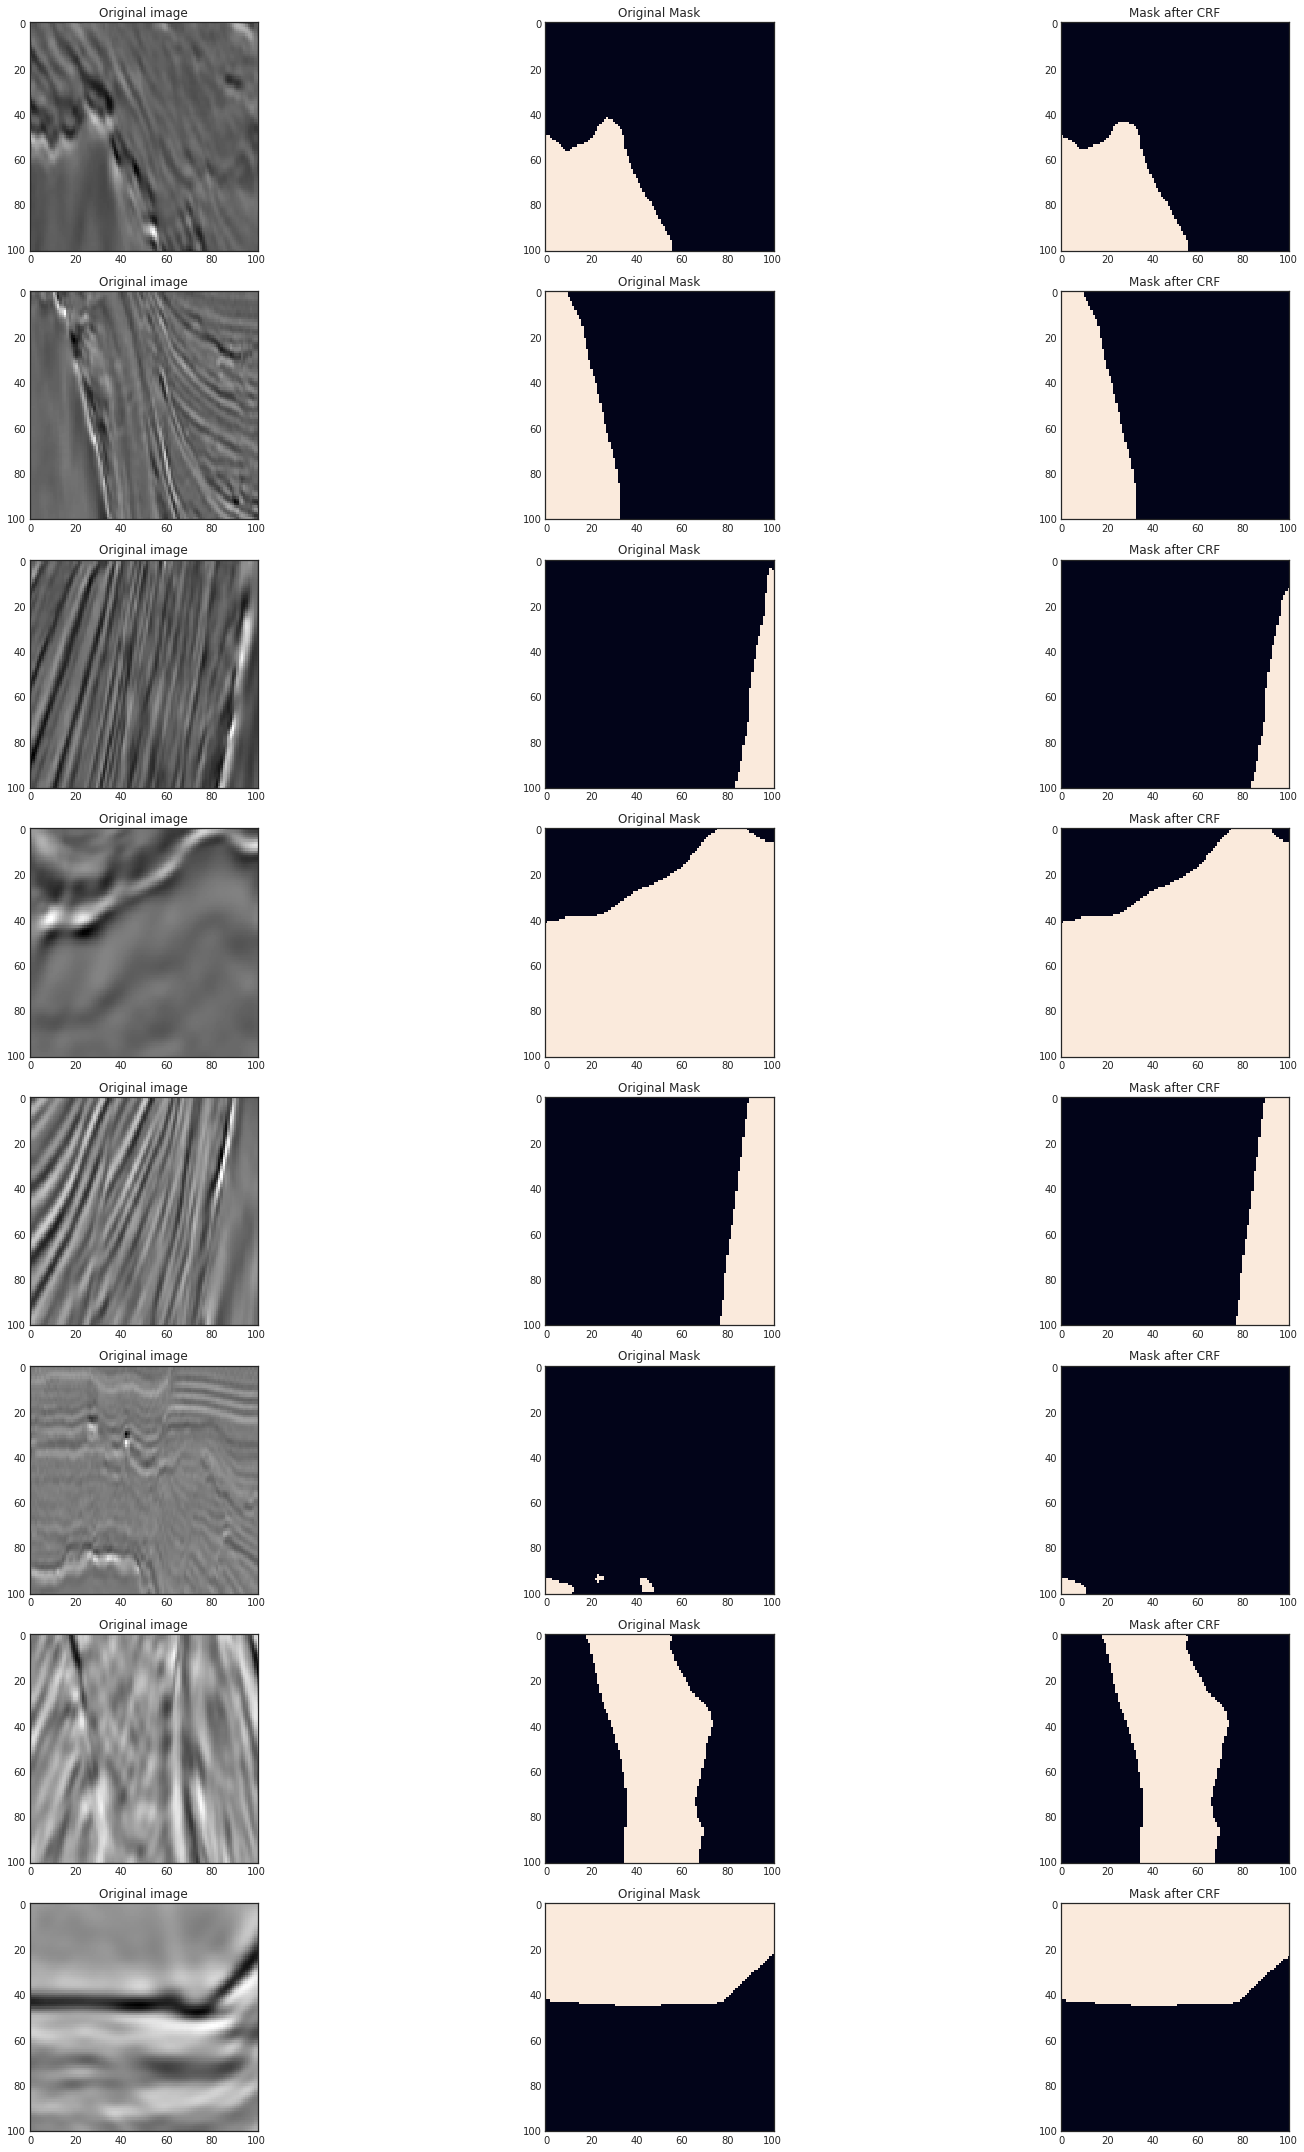

In [74]:
"""
visualizing the effect of applying CRF

"""
np.random.seed(100)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

In [75]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [76]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm_notebook(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

A Jupyter Widget

In [77]:
df.to_csv('CRF_submission_CCC.csv',index=False)

# FAQ:

## [Dice loss 与 F1 score的关系](https://dev.to/andys0975/what-is-dice-loss-for-image-segmentation-3p85)